## Librerias

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



## Data

In [2]:
# Cargar el conjunto de datos de entrenamiento
train_df = pd.read_csv('./data/train.csv', index_col=0)


## Data exploration

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [5]:

train_df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
laptop_ID,,,,,,,,,,,,
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [3]:
cardinalidad = train_df.nunique()
per_cardinalidad = (cardinalidad / len(train_df)) * 100

cardinalidad_df = pd.DataFrame({'Cardinalidad': cardinalidad, 'Porcentaje (%)': per_cardinalidad})

cardinalidad_df

,Cardinalidad,Porcentaje (%)
Company,19,2.083333
Product,480,52.631579
TypeName,6,0.657895
Inches,17,1.864035
ScreenResolution,36,3.947368
Cpu,107,11.732456
Ram,9,0.986842
Memory,37,4.057018
Gpu,93,10.197368
OpSys,9,0.986842


In [ ]:
'''
- Product: cardinalidad demadiado alta --> no parece que sea muy importante. Eliminar?
- Cpu y Gpu: cardinalidad alta --> tratamiento específico o eliminarlas?. Tienen info importante
- TypeName, Company y OpSyS: cardinalidad baja --> tratamiento específico. Tienen info importante
- Memory: cardinalidad baja --> tratamiento específico. Tal vez quitarle los strings y transformarla de una manera que el modelo entienda la info
- ScreenResolution: cardinalidad baja --> tratamiento específico. Tal vez quitarle los strings y transformarla de una manera que el modelo entienda la info
'''

## Data processing

El target es la columna `Price_in_euros`

In [ ]:
'''
'Ram' y 'Weight' son columnas importantes, sólo necesito quitarles los strings para poder trabajar con ellas
'''

In [3]:
# Limpiar y convertir las columnas "Ram" y "Weight" a formato numérico

# convertir a entero
train_df['Ram'] = train_df['Ram'].str.replace('GB', '').astype(int)

# convertir a float
train_df['Weight'] = train_df['Weight'].str.replace('kg', '').astype(float)

# revisar
train_df[['Ram', 'Weight']].head()


,Ram,Weight
laptop_ID,,
755,8,1.86
618,16,2.59
909,8,2.04
2,8,1.34
286,4,2.25


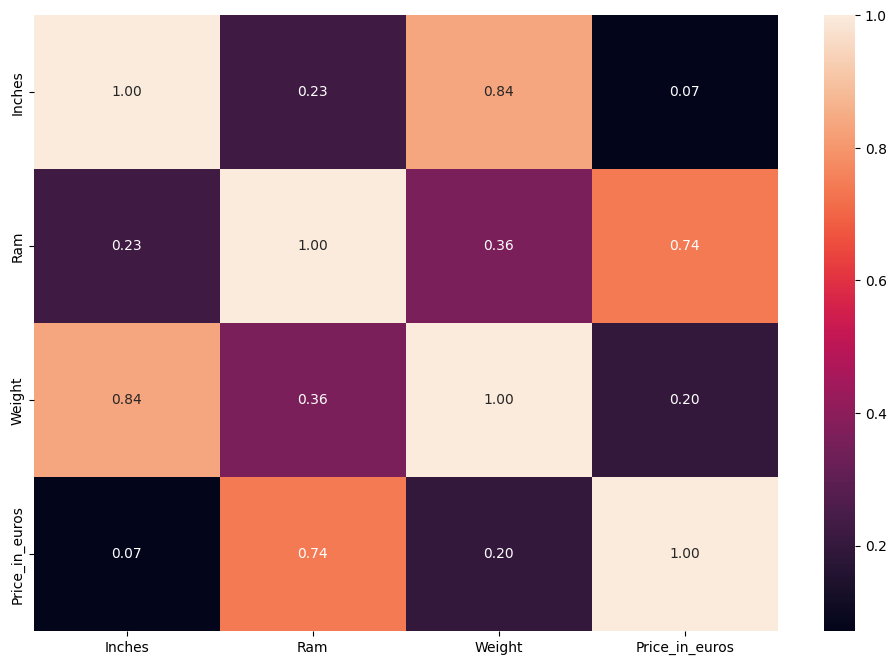

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionamos solo las columnas numéricas para calcular la matriz de correlación
numeric_df = train_df.select_dtypes(include=['float64', 'int64'])

# Calculamos la matriz de correlación solo para las variables numéricas
corr_matrix = numeric_df.corr()

# Dibujamos el mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

In [ ]:
'''
- Ram tiene una fuerte correlación positiva con Price_in_euros -->  más RAM mayor es el precio
- Weight tiene una correlación positiva baja con Price_in_euros --> más peso no tiene por quñe significar siempre más precio del ordenador 
'''

In [ ]:
'''
'Product' tiene una cardinalidad demasiado alta. Creo que la mejor opción es iliminarla directamente:

- mantener la columna aumenta la dimensionalidad de los datos
- mantener features con una cardinalidad exageradamente alta puede dificultar el entrenamient del modelo

'''

In [4]:
# Eliminar  la columna 'Product'
train_df.drop('Product', axis=1, inplace=True)

In [ ]:
'''
'Company', 'TypeName', 'OpSys' tienen una cardinalidad baja.

Creo que la mejor opción es aplicar get_dummies ya que al tener la cardinalidad baja no me subirá demasiado la dimensionalidad

'''

In [5]:
# get_dummies a las columnas específicas y eliminar las originales con el argumento 'columns'
train_df = pd.get_dummies(train_df, columns=['Company', 'TypeName', 'OpSys'])



In [8]:
train_df.head()

,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,Weight,Price_in_euros,Company_Acer,Company_Apple,...,TypeName_Workstation,OpSys_Android,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
laptop_ID,,,,,,,,,,,,,,,,,,,,,
755,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8,256GB SSD,Intel HD Graphics 520,1.86,539.00,False,False,...,False,False,False,False,False,False,True,False,False,False
618,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16,1TB HDD,Nvidia GeForce GTX 960<U+039C>,2.59,879.01,False,False,...,False,False,False,False,False,False,True,False,False,False
909,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8,1TB HDD,Nvidia GeForce 930MX,2.04,900.00,False,False,...,False,False,False,False,False,False,True,False,False,False
2,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,1.34,898.94,False,True,...,False,False,False,False,False,False,False,False,False,True
286,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4,1TB HDD,AMD Radeon R5 M430,2.25,428.00,False,False,...,False,False,False,True,False,False,False,False,False,False
627,14.0,1366x768,Intel Core i5 7300U 2.6GHz,8,256GB SSD,Intel HD Graphics 620,2.31,1124.00,False,False,...,False,False,False,False,False,False,True,False,False,False
142,13.3,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4,256GB SSD,Intel HD Graphics 620,1.32,699.00,False,False,...,False,False,False,False,False,False,True,False,False,False
19,15.6,Full HD 1920x1080,Intel Core i3 7100U 2.4GHz,8,1TB HDD,Nvidia GeForce 940MX,2.20,499.00,False,False,...,False,False,False,False,False,True,False,False,False,False
732,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,2.70,1348.48,False,False,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
'''
'Memory' contiene info interesante que quiero mantener, por lo que debo transformarla:

- Se puede observar que la cardinalidad no es muy alta, realmente hay pocos tipos de memoria diferentes
- Lo que aumenta la variedad es el hecho de las especificaciones de cada gran grupo
- Puedo quedarme sólo con lo importante y simplificar la información 
- Analizo los componentes principales y hago una selección de las opciones más relevantes y las convierto a binarias: ['SSD', 'HDD' y 'Flash Storage']

'''

In [8]:
train_df['Memory'].value_counts().head(25)

Memory
256GB SSD               282
1TB HDD                 152
500GB HDD                92
512GB SSD                83
128GB SSD +  1TB HDD     67
128GB SSD                54
256GB SSD +  1TB HDD     52
32GB Flash Storage       33
1TB SSD                  12
64GB Flash Storage       11
512GB SSD +  1TB HDD      8
2TB HDD                   8
256GB Flash Storage       7
16GB Flash Storage        6
256GB SSD +  2TB HDD      6
32GB SSD                  5
1.0TB Hybrid              5
128GB Flash Storage       4
180GB SSD                 3
16GB SSD                  3
512GB SSD +  2TB HDD      2
1TB SSD +  1TB HDD        2
1TB HDD +  1TB HDD        1
512GB Flash Storage       1
1.0TB HDD                 1
Name: count, dtype: int64

In [6]:
# nueva columna  'SSD' 
# apply para aplicar una operación a cada uno de los elementos de cada fila
# verifica si el texto 'SSD' está presente en la fila (x)
# si 'SSD' existe añade un 1 si es diferente 0
train_df['SSD'] = train_df['Memory'].apply(lambda x: 1 if 'SSD' in x else 0)

# lo mismo para 'HDD'
train_df['HDD'] = train_df['Memory'].apply(lambda x: 1 if 'HDD' in x else 0)

# lo mismo para 'Flash Storage'
train_df['Flash_Storage'] = train_df['Memory'].apply(lambda x: 1 if 'Flash' in x else 0)

# lo mismo para 'Hybrid'
train_df['Hybrid'] = train_df['Memory'].apply(lambda x: 1 if 'Hybrid' in x else 0)

In [7]:
# elimino la la columna base
train_df.drop('Memory', axis=1, inplace=True)

In [11]:
train_df.head()

,Inches,ScreenResolution,Cpu,Ram,Gpu,Weight,Price_in_euros,Company_Acer,Company_Apple,Company_Asus,...,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,SSD,HDD,Flash_Storage,Hybrid
laptop_ID,,,,,,,,,,,,,,,,,,,,,
755,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8,Intel HD Graphics 520,1.86,539.00,False,False,False,...,False,False,True,False,False,False,1,0,0,0
618,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16,Nvidia GeForce GTX 960<U+039C>,2.59,879.01,False,False,False,...,False,False,True,False,False,False,0,1,0,0
909,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8,Nvidia GeForce 930MX,2.04,900.00,False,False,False,...,False,False,True,False,False,False,0,1,0,0
2,13.3,1440x900,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,1.34,898.94,False,True,False,...,False,False,False,False,False,True,0,0,1,0
286,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4,AMD Radeon R5 M430,2.25,428.00,False,False,False,...,False,False,False,False,False,False,0,1,0,0


In [ ]:
'''
'Gpu' y 'Cpu' contienen info muy relevante interesante que quiero mantener, por lo que debo transformarla:

- Voy a aplicar la misma técnica que con 'Memory':
- Analizar cuáles son los grupos más representativos 
- Crear nuevas columnas binarias a partir de esa información
- Analizo los componentes principales y hago una selección de las opciones más relevantes y las convierto a binarias: ['Intel', 'HDD' y 'Flash Storage']

'''

In [15]:
train_df['Gpu'].value_counts().head(25)


Gpu
Intel HD Graphics 620         185
Intel HD Graphics 520         125
Intel UHD Graphics 620         52
Nvidia GeForce GTX 1050        48
Nvidia GeForce 940MX           31
Nvidia GeForce GTX 1060        31
Intel HD Graphics 400          30
Intel HD Graphics 500          27
Intel HD Graphics              25
Nvidia GeForce GTX 1070        22
AMD Radeon 530                 22
Nvidia GeForce GTX 1050 Ti     21
AMD Radeon R5 M430             18
Nvidia GeForce 930MX           17
Intel HD Graphics 515          12
Nvidia GeForce GTX 960M        12
AMD Radeon 520                 11
Nvidia GeForce MX150           10
Nvidia GeForce 920MX           10
Intel HD Graphics 615          10
Intel HD Graphics 405           8
Intel HD Graphics 505           8
AMD Radeon R7 M445              7
AMD Radeon R5 M420              7
Nvidia GeForce GTX 950M         7
Name: count, dtype: int64

In [16]:
train_df['Cpu'].value_counts().head(25)

Cpu
Intel Core i5 7200U 2.5GHz              124
Intel Core i7 7700HQ 2.8GHz             105
Intel Core i7 7500U 2.7GHz               97
Intel Core i5 8250U 1.6GHz               52
Intel Core i7 8550U 1.8GHz               47
Intel Core i3 6006U 2GHz                 45
Intel Core i5 6200U 2.3GHz               44
Intel Core i7 6500U 2.5GHz               40
Intel Core i7 6700HQ 2.6GHz              30
Intel Celeron Dual Core N3060 1.6GHz     25
Intel Celeron Dual Core N3350 1.1GHz     22
Intel Core i3 7100U 2.4GHz               22
Intel Core i5 7300HQ 2.5GHz              21
Intel Core i3 6006U 2.0GHz               11
Intel Core i7 7600U 2.8GHz               11
Intel Pentium Quad Core N3710 1.6GHz     10
Intel Celeron Dual Core N3050 1.6GHz     10
Intel Pentium Quad Core N4200 1.1GHz     10
Intel Core i7 6600U 2.6GHz                9
Intel Core i5 6300U 2.4GHz                8
Intel Core i3 6100U 2.3GHz                7
Intel Core i5 7300U 2.6GHz                7
Intel Core i5 6300HQ 2.3GHz 

In [ ]:
'''
Tras analizar los datos:
- GPU: voy a quedarme con las tres marcas principales que recogen la mayoría de la info ['Intel', 'Nvidia' y 'AMD']
- CPU: en este caso, la mayoría de los valores pertenecen a 'Intel', por lo que prefiero distinguir entre la generación de su CPU. También creo una genérica para AMD
'''

In [8]:

# creo nuevas columnas binarias para las tres marcas princpales de gráficas
train_df['GPU_Intel'] = train_df['Gpu'].apply(lambda x: 1 if 'Intel' in x else 0) # usar el in para que el código reconozca si se encuentra la subcadena de texto seleccionada y no compare con todo el texto completo
train_df['GPU_Nvidia'] = train_df['Gpu'].apply(lambda x: 1 if 'Nvidia' in x else 0)
train_df['GPU_AMD'] = train_df['Gpu'].apply(lambda x: 1 if 'AMD' in x else 0)


In [9]:
# Creación de nuevas columnas binarias para CPU
train_df['CPU_Intel_Core_i3'] = train_df['Cpu'].apply(lambda x: 1 if 'Intel Core i3' in x else 0)
train_df['CPU_Intel_Core_i5'] = train_df['Cpu'].apply(lambda x: 1 if 'Intel Core i5' in x else 0)
train_df['CPU_Intel_Core_i7'] = train_df['Cpu'].apply(lambda x: 1 if 'Intel Core i7' in x else 0)
train_df['CPU_Intel_Core_i9'] = train_df['Cpu'].apply(lambda x: 1 if 'Intel Core i9' in x else 0)

# añado también AMD pero no distingo entre sus componenete; creo que no merece la pena porque no hay muchos
train_df['CPU_AMD'] = train_df['Cpu'].apply(lambda x: 1 if 'AMD' in x else 0)



In [10]:
# elimino las columna base
train_df.drop('Cpu', axis=1, inplace=True)
train_df.drop('Gpu', axis=1, inplace=True)

In [ ]:
'''
'Screen Resolution' también creo se trasta de una feature que puede aportar valor, por lo que realizo el mismo tratamiento visto anteriormente 
- Analizo los valores más recurrentes y a partir de estos creo nuevas columnas binarias
- CPU: en este caso, la mayoría de los valores pertenecen a 'Intel', por lo que prefiero distinguir entre la generación de su CPU. También creo una genérica para AMD
'''

In [19]:
train_df['ScreenResolution'].value_counts().head(25)

ScreenResolution
Full HD 1920x1080                                349
1366x768                                         211
IPS Panel Full HD 1920x1080                      163
IPS Panel Full HD / Touchscreen 1920x1080         32
Full HD / Touchscreen 1920x1080                   30
1600x900                                          14
Quad HD+ / Touchscreen 3200x1800                  11
Touchscreen 1366x768                              11
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     10
4K Ultra HD / Touchscreen 3840x2160                7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
Touchscreen 2560x1440                              6
IPS Panel 4K Ultra HD 3840x2160                    5
Touchscreen 2256x1504                              5
IPS Panel Retina Display 2560x1600                 5
1440x900                                           4
IPS Panel 1366x768                                 4
IPS Panel Retina Display 2304x1440                 4
IPS Panel Touchscreen 2560x14

In [11]:
# Crear columnas binarias basadas en los valores más recurrentes  de 'ScreenResolution'
train_df['Resolution_Full_HD'] = train_df['ScreenResolution'].apply(lambda x: 1 if '1920x1080' in x else 0)
train_df['Resolution_4K_Ultra_HD'] = train_df['ScreenResolution'].apply(lambda x: 1 if '3840x2160' in x else 0)
train_df['Screen_IPS'] = train_df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)
train_df['Screen_Touchscreen'] = train_df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
train_df['Resolution_Quad_HD'] = train_df['ScreenResolution'].apply(lambda x: 1 if '3200x1800' in x else 0)


In [12]:
train_df.drop('ScreenResolution', axis=1, inplace=True)

In [24]:
train_df.head()

,Inches,Ram,Weight,Price_in_euros,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,...,CPU_Intel_Core_i3,CPU_Intel_Core_i5,CPU_Intel_Core_i7,CPU_Intel_Core_i9,CPU_AMD,Resolution_Full_HD,Resolution_4K_Ultra_HD,Screen_IPS,Screen_Touchscreen,Resolution_Quad_HD
laptop_ID,,,,,,,,,,,,,,,,,,,,,
755,15.6,8,1.86,539.00,False,False,False,False,False,False,...,1,0,0,0,0,1,0,0,0,0
618,15.6,16,2.59,879.01,False,False,False,False,True,False,...,0,0,1,0,0,1,0,0,0,0
909,15.6,8,2.04,900.00,False,False,False,False,False,False,...,0,0,1,0,0,1,0,0,0,0
2,13.3,8,1.34,898.94,False,True,False,False,False,False,...,0,1,0,0,0,0,0,0,0,0
286,15.6,4,2.25,428.00,False,False,False,False,True,False,...,1,0,0,0,0,1,0,0,0,0


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Inches                       912 non-null    float64
 1   Ram                          912 non-null    int64  
 2   Weight                       912 non-null    float64
 3   Price_in_euros               912 non-null    float64
 4   Company_Acer                 912 non-null    bool   
 5   Company_Apple                912 non-null    bool   
 6   Company_Asus                 912 non-null    bool   
 7   Company_Chuwi                912 non-null    bool   
 8   Company_Dell                 912 non-null    bool   
 9   Company_Fujitsu              912 non-null    bool   
 10  Company_Google               912 non-null    bool   
 11  Company_HP                   912 non-null    bool   
 12  Company_Huawei               912 non-null    bool   
 13  Company_LG             

-----------------------------------------------------------------------------------------------------------------

## Modelado

### 1. Definir X e y

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X = train_df.drop(['Price_in_euros'], axis=1)
y = train_df['Price_in_euros']




In [14]:
y.shape

(912,)

### 2. Dividir X_train, X_test, y_train, y_test

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
X_train

,Inches,Ram,Weight,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,...,CPU_Intel_Core_i3,CPU_Intel_Core_i5,CPU_Intel_Core_i7,CPU_Intel_Core_i9,CPU_AMD,Resolution_Full_HD,Resolution_4K_Ultra_HD,Screen_IPS,Screen_Touchscreen,Resolution_Quad_HD
laptop_ID,,,,,,,,,,,,,,,,,,,,,
1118,17.3,8,3.00,False,False,False,False,False,False,False,...,0,0,1,0,0,1,0,1,0,0
153,15.6,16,2.56,False,False,False,False,True,False,False,...,0,0,1,0,0,1,0,0,0,0
275,13.3,8,1.37,False,True,False,False,False,False,False,...,0,1,0,0,0,0,0,1,0,0
1100,14.0,4,1.54,False,False,False,False,False,False,False,...,0,1,0,0,0,1,0,0,0,0
131,17.3,16,2.80,False,False,False,False,True,False,False,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,14.0,8,1.94,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
996,15.6,6,2.20,False,False,False,False,False,False,False,...,0,0,0,0,1,1,0,0,0,0
770,12.5,16,1.18,False,False,False,False,True,False,False,...,0,0,1,0,0,1,0,0,0,0


### 3. Baseline de modelos


In [ ]:
'''
Qué modelo elegir?
Anteriormente, hice pruebas con diferentes modelos, pero finalmente me decanto por el RandomForest:

- Manejo de la complejidad: Capaz de capturar relaciones no lineales y complejas entre las características y la variable objetivo.
- Robustez frente a overfitting: Con un número adecuado de árboles y técnicas de poda, maneja bien el riesgo de sobreajuste.
- Versatilidad: Funciona bien con una amplia gama de tipos de datos y estructuras, incluyendo características categóricas sin necesidad de transformación previa. 
- Buen rendimiento: Un RMSE bajoo indica que las predicciones están razonablemente cerca de los valores reales, lo que sugiere un modelo efectivo para este conjunto de datos. --> LA MEJOR NOTA LA OBTENGO CON ESTE MODELO
- Mejora continua: Ofrece oportunidades de ajuste fino mediante la optimización de hiperparámetros para mejorar aún más el rendimiento.
'''

In [ ]:
'''
Una vez tengo claro que RandomForest es la mejor opción preparo un proceso de selección y evaluación
para descubrir qué combinación de hiperparámetros funciona mejor
'''

In [23]:

# ENTRENAMIENTO Y COMPARTIVA DE DIFERENTES HIPERPARAMETROS PARA DETECTAR LOS MEJORES AJUSTES

#  modelo e hiperparámetros 
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300], # nº de árboletes -->  más árboles más rendimiento pero también mayor complejidad al modelo
    'max_depth': [10, 20, 30, None], # profundidad máxima de cada árbol --> mucha profundidad puede provocar sobreajuste, igualemente quiero probar sin límite 'None' a ver qué pasa
    'min_samples_split': [2, 5, 10], # nº mínimo de muestras  para dividir un nodo --> valores medios-altos evitan complejidad exesiva pero muy altos pueden volver al modelo muy simple
    'min_samples_leaf': [1, 2, 4], # nº mínimo para ser hoja -->  prevenir el sobreajuste
    'max_features': ['auto', 'sqrt', 'log2'] # 'auto' usa todas las características | 'sqrt' usa la raíz cuadrada del número total de características en el dataset para buscar la mejor división | 'log2' usa el algoritmo base 2 para hacer la división
}

# GridSearchCV para encontrar la mejor combi de parámetros
# se usa el RF y el diccionario con los parámetros
# 5 validaciones cruzadas (división en 5 partes es suficiente)
# 'n_jobs=-1' indica al ordenador que haga uso de todos los procesadores del ordenador --> acelera el proceso pero casi explota el ordenador :)
# 'verbose=1' limita el nº de mensajes a mostrar 

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# Entrenar GridSearchCV con train
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus parámetros
best_rf = grid_search.best_estimator_ # nueva variable con el mejor modelo
best_params = grid_search.best_params_ # nueva variable que tiene un diccionario con los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)

# Evaluar el modelo con la métrica RMSE utilizando validación cruzada con los datos de train
cv_rmse = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_rmse)
print(f'CV RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}')

# Evaluar el modelo los datos de test
y_pred = best_rf.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE: {rmse_test}')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
CV RMSE: 296.1224444963963 ± 71.93109801287557
Test RMSE: 315.3976713988555


In [ ]:
'''
- La validación cruzada da una nota de 296.1224444963963
- Como es lógico, al hacer el predict contra la parte de datos de test, el RMSE sube a 315.3976713988555
'''

In [15]:


best_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)
best_rf.fit(X_train, y_train)


y_pred = best_rf.predict(X_test)

# Calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


RMSE: 315.3976713988555


In [28]:
best_rf

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=300,
                      random_state=42)

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de RMSE.

Random Forest - Buena Opción

- Manejo de la complejidad: Capaz de capturar relaciones no lineales y complejas entre las características y la variable objetivo.
- Robustez frente a overfitting: Con un número adecuado de árboles y técnicas de poda, maneja bien el riesgo de sobreajuste.
- Versatilidad: Funciona bien con una amplia gama de tipos de datos y estructuras, incluyendo características categóricas sin necesidad de transformación previa.
- Buen rendimiento: Un RMSE de 348.10 indica que las predicciones están razonablemente cerca de los valores reales, lo que sugiere un modelo efectivo para este conjunto de datos.
- Mejora continua: Ofrece oportunidades de ajuste fino mediante la optimización de hiperparámetros para mejorar aún más el rendimiento.

In [ ]:
'''

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# best_rf es tu modelo de Random Forest entrenado
# Elegir un árbol específico para visualizar. Por ejemplo, el primer árbol:
tree_to_visualize = best_rf.estimators_[0]

# Configurar el tamaño de la figura para la visualización
plt.figure(figsize=(20,10))

# Visualizar el árbol
plot_tree(tree_to_visualize, 
          feature_names=train_df.columns[:-1],  # Asumiendo que la última columna es la columna objetivo
          class_names=['Precio'],  # Puedes ajustar esto según tus necesidades
          filled=True, 
          impurity=False, 
          rounded=True)

# Mostrar la visualización
plt.show()
'''

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [16]:
# Cargar el conjunto de datos de prueba
test_df = pd.read_csv('./data/test.csv', index_col=0)


In [17]:


# RAM y Weight a numéricos
test_df['Ram'] = test_df['Ram'].str.replace('GB', '').astype(int)
test_df['Weight'] = test_df['Weight'].str.replace('kg', '').astype(float)

# Eliminar la columna 'Product'
test_df.drop('Product', axis=1, inplace=True)

# get_dummies a las columnas específicas
test_df = pd.get_dummies(test_df, columns=['Company', 'TypeName', 'OpSys'])

# columnas binarias basadas en 'Memory', 'Gpu', 'Cpu', y 'ScreenResolution'
test_df['SSD'] = test_df['Memory'].apply(lambda x: 1 if 'SSD' in x else 0)
test_df['HDD'] = test_df['Memory'].apply(lambda x: 1 if 'HDD' in x else 0)
test_df['Flash_Storage'] = test_df['Memory'].apply(lambda x: 1 if 'Flash' in x else 0)
test_df['Hybrid'] = test_df['Memory'].apply(lambda x: 1 if 'Hybrid' in x else 0)

test_df['GPU_Intel'] = test_df['Gpu'].apply(lambda x: 1 if 'Intel' in x else 0)
test_df['GPU_Nvidia'] = test_df['Gpu'].apply(lambda x: 1 if 'Nvidia' in x else 0)
test_df['GPU_AMD'] = test_df['Gpu'].apply(lambda x: 1 if 'AMD' in x else 0)

test_df['CPU_Intel_Core_i3'] = test_df['Cpu'].apply(lambda x: 1 if 'Intel Core i3' in x else 0)
test_df['CPU_Intel_Core_i5'] = test_df['Cpu'].apply(lambda x: 1 if 'Intel Core i5' in x else 0)
test_df['CPU_Intel_Core_i7'] = test_df['Cpu'].apply(lambda x: 1 if 'Intel Core i7' in x else 0)
test_df['CPU_Intel_Core_i9'] = test_df['Cpu'].apply(lambda x: 1 if 'Intel Core i9' in x else 0)
test_df['CPU_AMD'] = test_df['Cpu'].apply(lambda x: 1 if 'AMD' in x else 0)

test_df['Resolution_Full_HD'] = test_df['ScreenResolution'].apply(lambda x: 1 if '1920x1080' in x else 0)
test_df['Resolution_4K_Ultra_HD'] = test_df['ScreenResolution'].apply(lambda x: 1 if '3840x2160' in x else 0)
test_df['Screen_IPS'] = test_df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)
test_df['Screen_Touchscreen'] = test_df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
test_df['Resolution_Quad_HD'] = test_df['ScreenResolution'].apply(lambda x: 1 if '3200x1800' in x else 0)

#  eliminar las columnas originales 
test_df.drop(['Memory', 'Gpu', 'Cpu', 'ScreenResolution'], axis=1, inplace=True)

# asegurar que no falten columnas en test_df en comparación con train_df y ajustar el orden de las columnas
missing_cols = set(train_df.columns) - set(test_df.columns)
for c in missing_cols:
    test_df[c] = 0  # Añadir las columnas faltantes con valor 0

 # Asegurar que todas las columnas en test_df estén en el mismo orden que en train_df, excepto la columna objetivo
test_df = test_df[[col for col in train_df.columns if col != 'Price_euros']]



In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Inches                       912 non-null    float64
 1   Ram                          912 non-null    int64  
 2   Weight                       912 non-null    float64
 3   Price_in_euros               912 non-null    float64
 4   Company_Acer                 912 non-null    bool   
 5   Company_Apple                912 non-null    bool   
 6   Company_Asus                 912 non-null    bool   
 7   Company_Chuwi                912 non-null    bool   
 8   Company_Dell                 912 non-null    bool   
 9   Company_Fujitsu              912 non-null    bool   
 10  Company_Google               912 non-null    bool   
 11  Company_HP                   912 non-null    bool   
 12  Company_Huawei               912 non-null    bool   
 13  Company_LG             

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Inches                       391 non-null    float64
 1   Ram                          391 non-null    int64  
 2   Weight                       391 non-null    float64
 3   Company_Acer                 391 non-null    bool   
 4   Company_Apple                391 non-null    bool   
 5   Company_Asus                 391 non-null    bool   
 6   Company_Chuwi                391 non-null    bool   
 7   Company_Dell                 391 non-null    bool   
 8   Company_Fujitsu              391 non-null    bool   
 9   Company_Google               391 non-null    bool   
 10  Company_HP                   391 non-null    bool   
 11  Company_LG                   391 non-null    bool   
 12  Company_Lenovo               391 non-null    bool   
 13  Company_MSI            

In [19]:
# Asegurarse de que 'Price_in_euros' no esté en test_df antes de hacer predicciones
if 'Price_in_euros' in test_df.columns:
    test_df.drop(columns=['Price_in_euros'], inplace=True)

In [20]:
predictions_submit = best_rf.predict(test_df)
predictions_submit

array([1288.78752333,  292.63699087,  414.65912222,  957.47430873,
        883.13648966,  514.9778    ,  742.957175  ,  963.18883333,
       1150.44391389,  393.24070556, 2273.40158095, 1245.75395556,
        465.06455913, 1444.02495714,  777.54868528,  710.11876016,
       2034.19912222, 1386.86183333, 1827.80795   ,  739.05525556,
       1385.17071833,  368.82791111,  791.34534889, 1124.51710833,
        516.02325921,  697.32396278,  529.10650952,  737.46297778,
       2655.5259481 , 1131.28294605, 2294.99767778,  439.6407133 ,
        832.80640044, 3101.62354587, 1834.78392222, 1964.27785101,
        693.77064524, 1350.3558    ,  961.95931344, 1654.0348    ,
        722.46646667,  786.37923333,  537.92722222, 1231.49226655,
       1253.99847778, 1099.04053492, 1024.85199357,  544.42818082,
        788.65235556,  555.1195746 , 1528.20141825,  739.8035    ,
       1179.8397127 ,  590.45790111, 1958.19481111, 1841.55303889,
        713.03817381,  982.15620333, 1084.66771111,  649.75518

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

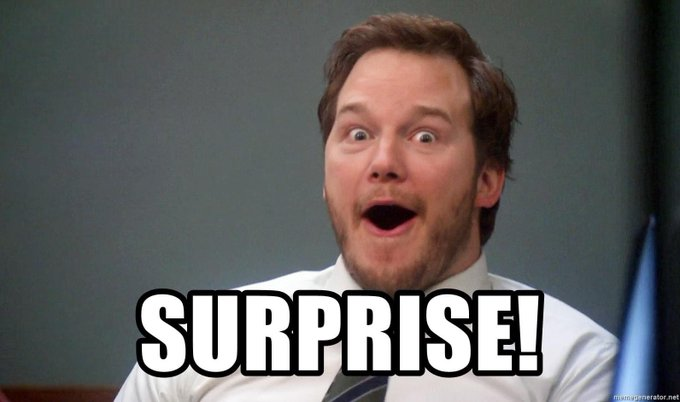

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [25]:
sample = pd.read_csv("data/sample_submission.csv")

In [29]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [30]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [21]:
submission = pd.DataFrame({
    'laptop_ID': test_df.index,  # Asegurándonos de que test_df.index contiene los ID de los laptops
    'Price_in_euros': predictions_submit  # Usar las predicciones almacenadas en predictions_submit
})

In [22]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [23]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Iván y Manuel: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `laptops_test.csv`. Lloramos.")

In [26]:
chequeador(submission)

You're ready to submit!


In [27]:
# Guardar el DataFrame como un archivo CSV para submission
submission.to_csv('submission_final_final_final.csv', index=False)